In [34]:
import pandas as pd
import numpy as np
import os
import shutil
from collections import Counter,defaultdict
import ast
import random
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import warnings
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=UserWarning) 

In [35]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # torch.use_deterministic_algorithms(True) 
    print(f"[INFO] Seed set to {seed}")
set_seed()

[INFO] Seed set to 42


Set the key path for the whole project.

In [36]:
csv_path = 'PTB_XL/ptbxl_database.csv'
df = pd.read_csv(csv_path)
selected_labels = {'AFIB', 'AFLT', '1AVB', 'CRBBB', 'CLBBB', 'NORM'}
npy_dir = 'PTB_XL/record100'
output_folder = 'PTB_selected_dataset'
dataset_selected = 'PTB_selected_dataset.csv'
train_dataset = "PTB_train.csv"
test_dataset = "PTB_test.csv"
best_model = "CBA_net_model/ECG_best_model.pt"
root_dir = "New_sample_to_test/validation"
test_dir = "New_sample_to_test/test"
final_prediction_model = "CBA_net_model/ECG_final_model.pt"

norm_sample_numbers = 1000
other_sample_numbers = 1000

In [37]:
all_label_counter = defaultdict(int)
for scp_str in df['scp_codes']:
    label_dict = ast.literal_eval(scp_str)
    for label, weight in label_dict.items():
        if weight != 0.0:
            all_label_counter[label] += 1

full_label_df = pd.DataFrame.from_dict(all_label_counter, orient='index', columns=['count'])
full_label_df = full_label_df.sort_values(by='count', ascending=False)
print("Total label distribution")
print(full_label_df)

Total label distribution
         count
NORM      9514
IMI       2676
ASMI      2357
LVH       2132
NDT       1825
LAFB      1623
ISC_      1272
IRBBB     1118
PVC       1027
1AVB       793
IVCD       787
ISCAL      659
NST_       559
CRBBB      541
CLBBB      536
ILMI       478
LAO/LAE    426
AMI        353
ALMI       288
PACE       287
ISCIN      218
INJAS      214
LMI        201
ISCIL      179
DIG        177
LPFB       177
ISCAS      169
INJAL      145
ISCLA      140
RVH        126
LNGQT      116
ANEUR      104
RAO/RAE     99
EL          96
WPW         79
ILBBB       77
AFLT        56
IPLMI       51
AFIB        48
ISCAN       44
PAC         37
IPMI        33
SEHYP       29
PSVT        24
BIGU        24
INJIN       18
INJLA       17
PMI         17
3AVB        16
INJIL       15
2AVB        14
STACH        4


Count the number of instances for each label

In [38]:
label_count = defaultdict(int)
for scp_str in df['scp_codes']:
    label_dict = ast.literal_eval(scp_str)  
    added_label = False
    for label, weight in label_dict.items():
        if weight != 0.0:
            if label in selected_labels:
                label_count[label] += 1
                added_label = True
    if not added_label:
        label_count['OTHERS'] += 1
label_df = pd.DataFrame.from_dict(label_count, orient='index', columns=['count'])
label_df = label_df.sort_values(by='count', ascending=False)
print(label_df)

        count
OTHERS  10514
NORM     9514
1AVB      793
CRBBB     541
CLBBB     536
AFLT       56
AFIB       48


Check whether the dataset complies with the specified sampling frequency

In [39]:
invalid_files = []
valid_files = []
expected_samples = 1000

for file in os.listdir(npy_dir):
    if not file.endswith('.npy'):
        continue

    file_path = os.path.join(npy_dir, file)
    try:
        data = np.load(file_path)
        if data.shape[0] != expected_samples:
            print(f"{file}: shape {data.shape} → samples != 1000")
            invalid_files.append((file, data.shape))
        else:
            valid_files.append(file)
    except Exception as e:
        print(f"Error loading {file}: {e}")
        invalid_files.append((file, 'load_error'))

print(f"Total valid files: {len(valid_files)}")
print(f"Total invalid files: {len(invalid_files)}")

Total valid files: 21799
Total invalid files: 0


Select data by retaining all required classes, and randomly sample 1,000 instances each for the 'NORM' and 'OTHER' categories

In [40]:
output_csv_path = dataset_selected
if os.path.exists(output_csv_path):
    print(f"{output_csv_path} already exists. Skipping file generation.")
else:
    os.makedirs(output_folder, exist_ok=True)

    df = pd.read_csv(csv_path)
    file_label_map = {}

    for _, row in df.iterrows():
        record_name = row['filename_lr'].replace('.hea', '')
        label_dict = ast.literal_eval(row['scp_codes'])
        label_assigned = 'OTHERS'
        for label, weight in label_dict.items():
            if weight != 0.0 and label in selected_labels:
                label_assigned = label
                break
        file_label_map[record_name] = label_assigned

    label_groups = defaultdict(list)
    for fname, label in file_label_map.items():
        label_groups[label].append(fname)
    random.seed(42)
    norm_sample = random.sample(label_groups['NORM'], min(norm_sample_numbers, len(label_groups['NORM'])))
    other_sample = random.sample(label_groups['OTHERS'], min(other_sample_numbers, len(label_groups['OTHERS'])))

    other_labels = set(label_groups.keys()) - {'NORM', 'OTHERS'}
    other_label_samples = []
    for l in other_labels:
        other_label_samples.extend(label_groups[l])

    all_selected = norm_sample + other_sample + other_label_samples

    def npy_path_from_name(name):
        base_name = f"converted_npy_{name.replace('/', '_').replace('records100_','')}.npy"
        return os.path.join(npy_dir, base_name)

    def is_valid_npy(path):
        try:
            data = np.load(path)
            return data.shape[0] == 1000
        except:
            return False

    copied = 0
    copied_records = []

    for name in all_selected:
        src_path = npy_path_from_name(name)
        if os.path.exists(src_path) and is_valid_npy(src_path):
            dst_path = os.path.join(output_folder, os.path.basename(src_path))
            shutil.copy(src_path, dst_path)
            copied_records.append((os.path.basename(src_path), file_label_map[name]))
            copied += 1
        else:
            print(f"Skipped: {src_path}")

    df_out = pd.DataFrame(copied_records, columns=["filename", "label"])
    df_out.to_csv(output_csv_path, index=False)

    print(f"Done. Total copied: {copied}")

PTB_selected_dataset.csv already exists. Skipping file generation.


In [41]:
label_df = pd.read_csv(dataset_selected)
unique_labels = sorted(label_df['label'].unique())
label_map = {label: idx for idx, label in enumerate(unique_labels)}
print("label map：", label_map)
label_df['label_id'] = label_df['label'].map(label_map)
label_df.to_csv(dataset_selected, index=False)
df = pd.read_csv(dataset_selected)
print(df.head())
print("\nColumns:", df.columns.tolist())
print("\ndtype of label_id:", df['label_id'].dtype)
print("\nLabel to ID mapping in file:")
print(df[['label', 'label_id']].drop_duplicates().sort_values('label_id'))
print("\nNull values check:")
print(df.isnull().sum())

label map： {'1AVB': 0, 'AFIB': 1, 'AFLT': 2, 'CLBBB': 3, 'CRBBB': 4, 'NORM': 5, 'OTHERS': 6}
                           filename label  label_id
0  converted_npy_03000_03459_lr.npy  NORM         5
1  converted_npy_00000_00774_lr.npy  NORM         5
2  converted_npy_09000_09501_lr.npy  NORM         5
3  converted_npy_08000_08306_lr.npy  NORM         5
4  converted_npy_07000_07570_lr.npy  NORM         5

Columns: ['filename', 'label', 'label_id']

dtype of label_id: int64

Label to ID mapping in file:
       label  label_id
2645    1AVB         0
2056    AFIB         1
2000    AFLT         2
3236   CLBBB         3
2104   CRBBB         4
0       NORM         5
1000  OTHERS         6

Null values check:
filename    0
label       0
label_id    0
dtype: int64


The dataset was split in a stratified manner to ensure that all classes are represented in both the training and test sets, thereby avoiding distribution bias due to purely random sampling.

In [42]:
label_df = pd.read_csv(dataset_selected)
train_list = []
test_list = []

for label, group in label_df.groupby('label_id'):
    train_part, test_part = train_test_split(
        group,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )
    train_list.append(train_part)
    test_list.append(test_part)

train_df = pd.concat(train_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)


In [43]:
train_df.to_csv(train_dataset, index=False)
test_df.to_csv(test_dataset, index=False)
print("Train distribution:\n", train_df['label_id'].value_counts().sort_index())
print("Test distribution:\n", test_df['label_id'].value_counts().sort_index())

Train distribution:
 label_id
0    472
1     38
2     44
3    428
4    432
5    800
6    800
Name: count, dtype: int64
Test distribution:
 label_id
0    119
1     10
2     12
3    107
4    109
5    200
6    200
Name: count, dtype: int64


Dataset loader

In [44]:
class ECGDataset(Dataset):
    def __init__(self, csv_file, data_dir):
        self.df = pd.read_csv(csv_file)
        self.data_dir = data_dir
        self.label_map = {label: idx for idx, label in enumerate(sorted(self.df['label'].unique()))}
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = os.path.join(self.data_dir, row['filename'])
        ecg = np.load(file_path)  # shape: (1000, 12)
        ecg = torch.tensor(ecg, dtype=torch.float32).transpose(0, 1)  # shape: (12, 1000)
        label = torch.tensor(row['label_id'], dtype=torch.long)
        return ecg, label

In [45]:
train_dataset = ECGDataset(train_dataset, output_folder)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = ECGDataset(test_dataset, output_folder)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [46]:
for ecg, label in train_loader:
    print("ECG shape:", ecg.shape)  # (B, 12, 1000)
    print("Label shape:", label.shape)  # (B,)
    break

ECG shape: torch.Size([32, 12, 1000])
Label shape: torch.Size([32])


The mian model of CBA-net

In [47]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, input_dim, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        assert input_dim % num_heads == 0, "input_dim must be divisible by num_heads"
        self.q_proj = nn.Linear(input_dim, input_dim)
        self.k_proj = nn.Linear(input_dim, input_dim)
        self.v_proj = nn.Linear(input_dim, input_dim)
        self.out_proj = nn.Linear(input_dim, input_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, T, D = x.shape  # (B, T, D)
        H = self.num_heads
        d = self.head_dim
        Q = self.q_proj(x).view(B, T, H, d).transpose(1, 2)  # (B, H, T, d)
        K = self.k_proj(x).view(B, T, H, d).transpose(1, 2)
        V = self.v_proj(x).view(B, T, H, d).transpose(1, 2)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (d ** 0.5)  # (B, H, T, T)
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context = torch.matmul(attn_weights, V)  # (B, H, T, d)
        context = context.transpose(1, 2).contiguous().view(B, T, D)  # (B, T, D)

        output = self.out_proj(context.mean(dim=1))  
        return output  # (B, D)

In [48]:
class ECGCNNBiLSTM_Attn(nn.Module):
    def __init__(self, n_classes):
        super(ECGCNNBiLSTM_Attn, self).__init__()
        self.conv1 = nn.Conv1d(12, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=1,
                            batch_first=True, bidirectional=True)

        # Multi-Head Self-Attention
        self.mh_attention = MultiHeadSelfAttention(input_dim=128 * 2, num_heads=4)

        self.fc = nn.Linear(128 * 2, n_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = x.transpose(1, 2)         # (B, T, C)
        lstm_out, _ = self.lstm(x)    # (B, T, 256)

        x = self.mh_attention(lstm_out)  # (B, 256)
        x = self.fc(x)                  # (B, n_classes)
        return x

In [49]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    acc = correct / total
    print(f"→ Eval Acc: {acc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    num_classes = cm.shape[0]
    specificity_list = []

    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificity_list.append(specificity)

    print("\nSpecificity per class:")
    for i, spec in enumerate(specificity_list):
        print(f"Class {i}: {spec:.4f}")

    return acc

In [50]:
def train_model(model, train_loader, test_loader, label_df, num_epochs=10, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f"Using device: {device}")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    classes = np.unique(label_df['label_id'])
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=label_df['label_id'])
    weights = torch.tensor(weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)

    best_acc = 0
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        print(f"\n[Epoch {epoch+1}/{num_epochs}]")
        loop = tqdm(train_loader, desc="Training", leave=False)

        for x_batch, y_batch in loop:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

            loop.set_postfix(loss=loss.item(), acc=correct / total)

        train_acc = correct / total
        print(f"→ Train Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f}")

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)

        test_acc = evaluate(model, test_loader, device)

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), best_model)
            print(f"Best model updated (acc={best_acc:.4f})")

    return train_losses, train_accuracies

In [51]:
def plot_metrics(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, marker='s')
    plt.title('Training Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [52]:
n_classes = len(train_df['label_id'].unique())
print(n_classes)

7


In [53]:

model = ECGCNNBiLSTM_Attn(n_classes)
train_losses, train_accuracies = train_model(model, train_loader, test_loader, label_df, num_epochs=25, lr=1e-2)

Using device: cuda

[Epoch 1/25]


→ Train Loss: 158.7977 | Train Acc: 0.3517
→ Eval Acc: 0.4954

Classification Report:
              precision    recall  f1-score   support

           0     0.4545    0.0420    0.0769       119
           1     0.0000    0.0000    0.0000        10
           2     0.1250    0.5833    0.2059        12
           3     0.6753    0.9720    0.7969       107
           4     0.4839    0.9633    0.6442       109
           5     0.4886    0.6450    0.5560       200
           6     0.4545    0.1250    0.1961       200

    accuracy                         0.4954       757
   macro avg     0.3831    0.4758    0.3537       757
weighted avg     0.4878    0.4954    0.4195       757


Specificity per class:
Class 0: 0.9906
Class 1: 1.0000
Class 2: 0.9342
Class 3: 0.9231
Class 4: 0.8272
Class 5: 0.7576
Class 6: 0.9461
Best model updated (acc=0.4954)

[Epoch 2/25]


→ Train Loss: 137.6922 | Train Acc: 0.4390
→ Eval Acc: 0.5799

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       119
           1     0.0000    0.0000    0.0000        10
           2     0.3438    0.9167    0.5000        12
           3     0.6688    0.9626    0.7893       107
           4     0.9623    0.9358    0.9488       109
           5     0.4680    0.9150    0.6193       200
           6     0.5405    0.2000    0.2920       200

    accuracy                         0.5799       757
   macro avg     0.4262    0.5614    0.4499       757
weighted avg     0.5050    0.5799    0.4969       757


Specificity per class:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 0.9718
Class 3: 0.9215
Class 4: 0.9938
Class 5: 0.6266
Class 6: 0.9390
Best model updated (acc=0.5799)

[Epoch 3/25]


→ Train Loss: 113.9309 | Train Acc: 0.4967
→ Eval Acc: 0.5033

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       119
           1     0.0488    0.2000    0.0784        10
           2     0.5294    0.7500    0.6207        12
           3     0.7407    0.9346    0.8264       107
           4     0.8710    0.9908    0.9270       109
           5     0.0000    0.0000    0.0000       200
           6     0.3690    0.8100    0.5070       200

    accuracy                         0.5033       757
   macro avg     0.3656    0.5265    0.4228       757
weighted avg     0.3366    0.5033    0.3951       757


Specificity per class:
Class 0: 0.9984
Class 1: 0.9478
Class 2: 0.9893
Class 3: 0.9462
Class 4: 0.9753
Class 5: 1.0000
Class 6: 0.5027

[Epoch 4/25]


→ Train Loss: 109.8140 | Train Acc: 0.5007
→ Eval Acc: 0.5429

Classification Report:
              precision    recall  f1-score   support

           0     0.4000    0.0336    0.0620       119
           1     0.0000    0.0000    0.0000        10
           2     0.5000    1.0000    0.6667        12
           3     0.7153    0.9626    0.8207       107
           4     0.9352    0.9266    0.9309       109
           5     0.6552    0.1900    0.2946       200
           6     0.3864    0.7650    0.5134       200

    accuracy                         0.5429       757
   macro avg     0.5131    0.5540    0.4698       757
weighted avg     0.5817    0.5429    0.4838       757


Specificity per class:
Class 0: 0.9906
Class 1: 0.9772
Class 2: 0.9839
Class 3: 0.9369
Class 4: 0.9892
Class 5: 0.9641
Class 6: 0.5637

[Epoch 5/25]


→ Train Loss: 93.0419 | Train Acc: 0.5601
→ Eval Acc: 0.6407

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       119
           1     0.0870    0.2000    0.1212        10
           2     0.3636    1.0000    0.5333        12
           3     0.8095    0.9533    0.8755       107
           4     0.9369    0.9541    0.9455       109
           5     0.6978    0.6350    0.6649       200
           6     0.4964    0.6900    0.5774       200

    accuracy                         0.6407       757
   macro avg     0.4845    0.6332    0.5311       757
weighted avg     0.5718    0.6407    0.5982       757


Specificity per class:
Class 0: 0.9937
Class 1: 0.9719
Class 2: 0.9718
Class 3: 0.9631
Class 4: 0.9892
Class 5: 0.9013
Class 6: 0.7487
Best model updated (acc=0.6407)

[Epoch 6/25]


→ Train Loss: 92.0436 | Train Acc: 0.5790
→ Eval Acc: 0.5799

Classification Report:
              precision    recall  f1-score   support

           0     0.2959    0.4874    0.3683       119
           1     0.1000    0.6000    0.1714        10
           2     0.4444    1.0000    0.6154        12
           3     0.9216    0.8785    0.8995       107
           4     0.9145    0.9817    0.9469       109
           5     0.6389    0.8050    0.7124       200
           6     0.3333    0.0050    0.0099       200

    accuracy                         0.5799       757
   macro avg     0.5212    0.6797    0.5320       757
weighted avg     0.5737    0.5799    0.5242       757


Specificity per class:
Class 0: 0.7837
Class 1: 0.9277
Class 2: 0.9799
Class 3: 0.9877
Class 4: 0.9846
Class 5: 0.8366
Class 6: 0.9964

[Epoch 7/25]


→ Train Loss: 85.1875 | Train Acc: 0.5740
→ Eval Acc: 0.6750

Classification Report:
              precision    recall  f1-score   support

           0     0.2857    0.0168    0.0317       119
           1     0.2857    0.2000    0.2353        10
           2     0.6923    0.7500    0.7200        12
           3     0.8455    0.9720    0.9043       107
           4     0.9364    0.9450    0.9406       109
           5     0.5912    0.9400    0.7259       200
           6     0.5754    0.5150    0.5435       200

    accuracy                         0.6750       757
   macro avg     0.6017    0.6198    0.5859       757
weighted avg     0.6222    0.6750    0.6182       757


Specificity per class:
Class 0: 0.9922
Class 1: 0.9933
Class 2: 0.9946
Class 3: 0.9708
Class 4: 0.9892
Class 5: 0.7666
Class 6: 0.8636
Best model updated (acc=0.6750)

[Epoch 8/25]


→ Train Loss: 86.6873 | Train Acc: 0.5766
→ Eval Acc: 0.6024

Classification Report:
              precision    recall  f1-score   support

           0     0.4037    0.3697    0.3860       119
           1     0.0000    0.0000    0.0000        10
           2     0.5238    0.9167    0.6667        12
           3     0.9009    0.9346    0.9174       107
           4     0.9224    0.9817    0.9511       109
           5     0.4862    0.9700    0.6477       200
           6     0.0000    0.0000    0.0000       200

    accuracy                         0.6024       757
   macro avg     0.4624    0.5961    0.5098       757
weighted avg     0.4604    0.6024    0.5090       757


Specificity per class:
Class 0: 0.8981
Class 1: 0.9987
Class 2: 0.9866
Class 3: 0.9831
Class 4: 0.9861
Class 5: 0.6320
Class 6: 1.0000

[Epoch 9/25]


→ Train Loss: 82.9603 | Train Acc: 0.5906
→ Eval Acc: 0.6579

Classification Report:
              precision    recall  f1-score   support

           0     0.3067    0.1933    0.2371       119
           1     0.0000    0.0000    0.0000        10
           2     0.6875    0.9167    0.7857        12
           3     0.8772    0.9346    0.9050       107
           4     0.9266    0.9266    0.9266       109
           5     0.6523    0.8350    0.7325       200
           6     0.5161    0.4800    0.4974       200

    accuracy                         0.6579       757
   macro avg     0.5666    0.6123    0.5835       757
weighted avg     0.6252    0.6579    0.6360       757


Specificity per class:
Class 0: 0.9185
Class 1: 0.9987
Class 2: 0.9933
Class 3: 0.9785
Class 4: 0.9877
Class 5: 0.8402
Class 6: 0.8384

[Epoch 10/25]


→ Train Loss: 75.4605 | Train Acc: 0.6082
→ Eval Acc: 0.6645

Classification Report:
              precision    recall  f1-score   support

           0     0.4684    0.3109    0.3737       119
           1     0.1818    0.4000    0.2500        10
           2     0.5789    0.9167    0.7097        12
           3     0.8870    0.9533    0.9189       107
           4     0.8583    1.0000    0.9237       109
           5     0.6217    0.8300    0.7109       200
           6     0.5781    0.3700    0.4512       200

    accuracy                         0.6645       757
   macro avg     0.5963    0.6830    0.6197       757
weighted avg     0.6512    0.6645    0.6432       757


Specificity per class:
Class 0: 0.9342
Class 1: 0.9759
Class 2: 0.9893
Class 3: 0.9800
Class 4: 0.9722
Class 5: 0.8187
Class 6: 0.9031

[Epoch 11/25]


→ Train Loss: 79.1228 | Train Acc: 0.6198
→ Eval Acc: 0.7081

Classification Report:
              precision    recall  f1-score   support

           0     0.4255    0.1681    0.2410       119
           1     0.5000    0.1000    0.1667        10
           2     0.7333    0.9167    0.8148        12
           3     0.9510    0.9065    0.9282       107
           4     0.9316    1.0000    0.9646       109
           5     0.6679    0.9050    0.7686       200
           6     0.5764    0.5850    0.5806       200

    accuracy                         0.7081       757
   macro avg     0.6837    0.6545    0.6378       757
weighted avg     0.6824    0.7081    0.6796       757


Specificity per class:
Class 0: 0.9577
Class 1: 0.9987
Class 2: 0.9946
Class 3: 0.9923
Class 4: 0.9877
Class 5: 0.8384
Class 6: 0.8456
Best model updated (acc=0.7081)

[Epoch 12/25]


→ Train Loss: 69.2701 | Train Acc: 0.6466
→ Eval Acc: 0.7239

Classification Report:
              precision    recall  f1-score   support

           0     0.4561    0.2185    0.2955       119
           1     0.6667    0.6000    0.6316        10
           2     0.6875    0.9167    0.7857        12
           3     0.9510    0.9065    0.9282       107
           4     0.9375    0.9633    0.9502       109
           5     0.7895    0.8250    0.8068       200
           6     0.5476    0.6900    0.6106       200

    accuracy                         0.7239       757
   macro avg     0.7194    0.7314    0.7155       757
weighted avg     0.7141    0.7239    0.7098       757


Specificity per class:
Class 0: 0.9514
Class 1: 0.9960
Class 2: 0.9933
Class 3: 0.9923
Class 4: 0.9892
Class 5: 0.9210
Class 6: 0.7953
Best model updated (acc=0.7239)

[Epoch 13/25]


→ Train Loss: 61.2610 | Train Acc: 0.7173
→ Eval Acc: 0.7318

Classification Report:
              precision    recall  f1-score   support

           0     0.5333    0.6050    0.5669       119
           1     0.3077    0.4000    0.3478        10
           2     0.7333    0.9167    0.8148        12
           3     0.9703    0.9159    0.9423       107
           4     0.9364    0.9450    0.9406       109
           5     0.7628    0.8200    0.7904       200
           6     0.6071    0.5100    0.5543       200

    accuracy                         0.7318       757
   macro avg     0.6930    0.7304    0.7082       757
weighted avg     0.7334    0.7318    0.7305       757


Specificity per class:
Class 0: 0.9013
Class 1: 0.9880
Class 2: 0.9946
Class 3: 0.9954
Class 4: 0.9892
Class 5: 0.9084
Class 6: 0.8815
Best model updated (acc=0.7318)

[Epoch 14/25]


→ Train Loss: 56.2851 | Train Acc: 0.7233
→ Eval Acc: 0.7609

Classification Report:
              precision    recall  f1-score   support

           0     0.5617    0.7647    0.6477       119
           1     0.6667    0.4000    0.5000        10
           2     0.6875    0.9167    0.7857        12
           3     0.8595    0.9720    0.9123       107
           4     0.8992    0.9817    0.9386       109
           5     0.7864    0.8100    0.7980       200
           6     0.7638    0.4850    0.5933       200

    accuracy                         0.7609       757
   macro avg     0.7464    0.7614    0.7394       757
weighted avg     0.7685    0.7609    0.7526       757


Specificity per class:
Class 0: 0.8887
Class 1: 0.9973
Class 2: 0.9933
Class 3: 0.9738
Class 4: 0.9815
Class 5: 0.9210
Class 6: 0.9461
Best model updated (acc=0.7609)

[Epoch 15/25]


→ Train Loss: 51.2520 | Train Acc: 0.7631
→ Eval Acc: 0.7160

Classification Report:
              precision    recall  f1-score   support

           0     0.7252    0.7983    0.7600       119
           1     0.2045    0.9000    0.3333        10
           2     0.7692    0.8333    0.8000        12
           3     0.9346    0.9346    0.9346       107
           4     0.7985    0.9817    0.8807       109
           5     0.6452    0.9000    0.7516       200
           6     0.8367    0.2050    0.3293       200

    accuracy                         0.7160       757
   macro avg     0.7020    0.7933    0.6842       757
weighted avg     0.7675    0.7160    0.6810       757


Specificity per class:
Class 0: 0.9436
Class 1: 0.9531
Class 2: 0.9960
Class 3: 0.9892
Class 4: 0.9583
Class 5: 0.8223
Class 6: 0.9856

[Epoch 16/25]


→ Train Loss: 49.9058 | Train Acc: 0.7757
→ Eval Acc: 0.7939

Classification Report:
              precision    recall  f1-score   support

           0     0.6299    0.8151    0.7106       119
           1     0.2857    0.8000    0.4211        10
           2     0.6471    0.9167    0.7586        12
           3     0.9533    0.9533    0.9533       107
           4     0.9397    1.0000    0.9689       109
           5     0.8159    0.8200    0.8180       200
           6     0.8209    0.5500    0.6587       200

    accuracy                         0.7939       757
   macro avg     0.7275    0.8364    0.7556       757
weighted avg     0.8155    0.7939    0.7937       757


Specificity per class:
Class 0: 0.9107
Class 1: 0.9732
Class 2: 0.9919
Class 3: 0.9923
Class 4: 0.9892
Class 5: 0.9336
Class 6: 0.9569
Best model updated (acc=0.7939)

[Epoch 17/25]


→ Train Loss: 45.9247 | Train Acc: 0.7916
→ Eval Acc: 0.7503

Classification Report:
              precision    recall  f1-score   support

           0     0.7368    0.7059    0.7210       119
           1     0.4667    0.7000    0.5600        10
           2     0.5000    0.9167    0.6471        12
           3     0.8281    0.9907    0.9021       107
           4     0.9464    0.9725    0.9593       109
           5     0.9151    0.4850    0.6340       200
           6     0.6038    0.7850    0.6826       200

    accuracy                         0.7503       757
   macro avg     0.7139    0.7937    0.7294       757
weighted avg     0.7846    0.7503    0.7445       757


Specificity per class:
Class 0: 0.9530
Class 1: 0.9893
Class 2: 0.9852
Class 3: 0.9662
Class 4: 0.9907
Class 5: 0.9838
Class 6: 0.8151

[Epoch 18/25]


→ Train Loss: 45.7002 | Train Acc: 0.7873
→ Eval Acc: 0.7345

Classification Report:
              precision    recall  f1-score   support

           0     0.7209    0.5210    0.6049       119
           1     0.1892    0.7000    0.2979        10
           2     0.3158    1.0000    0.4800        12
           3     1.0000    0.8692    0.9300       107
           4     0.9298    0.9725    0.9507       109
           5     0.7195    0.8850    0.7937       200
           6     0.6923    0.4950    0.5773       200

    accuracy                         0.7345       757
   macro avg     0.6525    0.7775    0.6621       757
weighted avg     0.7691    0.7345    0.7372       757


Specificity per class:
Class 0: 0.9624
Class 1: 0.9598
Class 2: 0.9651
Class 3: 1.0000
Class 4: 0.9877
Class 5: 0.8761
Class 6: 0.9210

[Epoch 19/25]


→ Train Loss: 45.2369 | Train Acc: 0.7847
→ Eval Acc: 0.7622

Classification Report:
              precision    recall  f1-score   support

           0     0.5117    0.9160    0.6566       119
           1     0.5000    0.8000    0.6154        10
           2     0.6000    1.0000    0.7500        12
           3     0.9700    0.9065    0.9372       107
           4     0.9596    0.8716    0.9135       109
           5     0.8086    0.8450    0.8264       200
           6     0.8700    0.4350    0.5800       200

    accuracy                         0.7622       757
   macro avg     0.7457    0.8249    0.7542       757
weighted avg     0.8153    0.7622    0.7588       757


Specificity per class:
Class 0: 0.8370
Class 1: 0.9893
Class 2: 0.9893
Class 3: 0.9954
Class 4: 0.9938
Class 5: 0.9282
Class 6: 0.9767

[Epoch 20/25]


→ Train Loss: 37.4211 | Train Acc: 0.8152
→ Eval Acc: 0.7939

Classification Report:
              precision    recall  f1-score   support

           0     0.6892    0.8571    0.7640       119
           1     0.3636    0.8000    0.5000        10
           2     0.6471    0.9167    0.7586        12
           3     0.9896    0.8879    0.9360       107
           4     0.9394    0.8532    0.8942       109
           5     0.8182    0.8100    0.8141       200
           6     0.7345    0.6500    0.6897       200

    accuracy                         0.7939       757
   macro avg     0.7402    0.8250    0.7652       757
weighted avg     0.8087    0.7939    0.7971       757


Specificity per class:
Class 0: 0.9279
Class 1: 0.9813
Class 2: 0.9919
Class 3: 0.9985
Class 4: 0.9907
Class 5: 0.9354
Class 6: 0.9156

[Epoch 21/25]


→ Train Loss: 37.0226 | Train Acc: 0.8232
→ Eval Acc: 0.8045

Classification Report:
              precision    recall  f1-score   support

           0     0.6763    0.7899    0.7287       119
           1     0.3704    1.0000    0.5405        10
           2     0.8333    0.8333    0.8333        12
           3     0.9060    0.9907    0.9464       107
           4     0.9474    0.9908    0.9686       109
           5     0.7692    0.9000    0.8295       200
           6     0.8860    0.5050    0.6433       200

    accuracy                         0.8045       757
   macro avg     0.7698    0.8585    0.7843       757
weighted avg     0.8262    0.8045    0.7973       757


Specificity per class:
Class 0: 0.9295
Class 1: 0.9772
Class 2: 0.9973
Class 3: 0.9831
Class 4: 0.9907
Class 5: 0.9031
Class 6: 0.9767
Best model updated (acc=0.8045)

[Epoch 22/25]


→ Train Loss: 38.2147 | Train Acc: 0.8179
→ Eval Acc: 0.7847

Classification Report:
              precision    recall  f1-score   support

           0     0.6761    0.8067    0.7356       119
           1     0.4091    0.9000    0.5625        10
           2     0.5238    0.9167    0.6667        12
           3     0.9901    0.9346    0.9615       107
           4     0.9524    0.9174    0.9346       109
           5     0.7115    0.9000    0.7947       200
           6     0.8673    0.4900    0.6262       200

    accuracy                         0.7847       757
   macro avg     0.7329    0.8379    0.7545       757
weighted avg     0.8142    0.7847    0.7795       757


Specificity per class:
Class 0: 0.9279
Class 1: 0.9826
Class 2: 0.9866
Class 3: 0.9985
Class 4: 0.9923
Class 5: 0.8689
Class 6: 0.9731

[Epoch 23/25]


→ Train Loss: 32.6759 | Train Acc: 0.8374
→ Eval Acc: 0.8045

Classification Report:
              precision    recall  f1-score   support

           0     0.7519    0.8151    0.7823       119
           1     0.5455    0.6000    0.5714        10
           2     0.7857    0.9167    0.8462        12
           3     0.9537    0.9626    0.9581       107
           4     0.9464    0.9725    0.9593       109
           5     0.8767    0.6400    0.7399       200
           6     0.6667    0.7900    0.7231       200

    accuracy                         0.8045       757
   macro avg     0.7895    0.8138    0.7972       757
weighted avg     0.8167    0.8045    0.8040       757


Specificity per class:
Class 0: 0.9498
Class 1: 0.9933
Class 2: 0.9960
Class 3: 0.9923
Class 4: 0.9907
Class 5: 0.9677
Class 6: 0.8582

[Epoch 24/25]


→ Train Loss: 29.2555 | Train Acc: 0.8474
→ Eval Acc: 0.8190

Classification Report:
              precision    recall  f1-score   support

           0     0.8455    0.7815    0.8122       119
           1     0.3200    0.8000    0.4571        10
           2     0.6111    0.9167    0.7333        12
           3     0.9804    0.9346    0.9569       107
           4     0.9000    0.9908    0.9432       109
           5     0.7561    0.9300    0.8341       200
           6     0.8382    0.5700    0.6786       200

    accuracy                         0.8190       757
   macro avg     0.7502    0.8462    0.7736       757
weighted avg     0.8362    0.8190    0.8161       757


Specificity per class:
Class 0: 0.9734
Class 1: 0.9772
Class 2: 0.9906
Class 3: 0.9969
Class 4: 0.9815
Class 5: 0.8923
Class 6: 0.9605
Best model updated (acc=0.8190)

[Epoch 25/25]


→ Train Loss: 32.1313 | Train Acc: 0.8378
→ Eval Acc: 0.8137

Classification Report:
              precision    recall  f1-score   support

           0     0.7113    0.8487    0.7739       119
           1     0.4375    0.7000    0.5385        10
           2     0.6875    0.9167    0.7857        12
           3     0.9623    0.9533    0.9577       107
           4     0.9459    0.9633    0.9545       109
           5     0.7812    0.8750    0.8255       200
           6     0.8099    0.5750    0.6725       200

    accuracy                         0.8137       757
   macro avg     0.7622    0.8331    0.7869       757
weighted avg     0.8211    0.8137    0.8098       757


Specificity per class:
Class 0: 0.9357
Class 1: 0.9880
Class 2: 0.9933
Class 3: 0.9938
Class 4: 0.9907
Class 5: 0.9120
Class 6: 0.9515


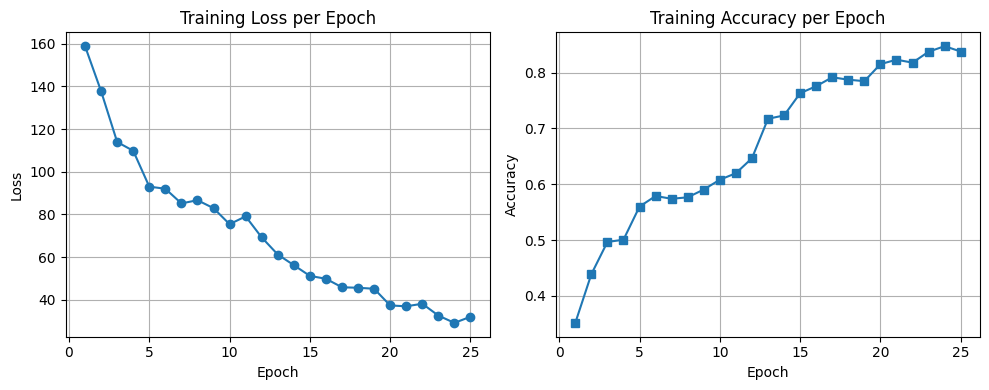

In [54]:
plot_metrics(train_losses, train_accuracies)

Model evaluation starts from this point. Currently, the best result from multiple training runs—final_prediction_model—is being used. If you wish to evaluate the current model instead, please set the final_prediction_model parameter to CBA_net_model/ECG_best_model.pt.

In [55]:
model = ECGCNNBiLSTM_Attn(n_classes)  
model.load_state_dict(torch.load(final_prediction_model))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

C:\Users\86185\AppData\Local\Temp\ipykernel_27492\1740257388.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(final_prediction_model))


ECGCNNBiLSTM_Attn(
  (conv1): Conv1d(12, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 128, batch_first=True, bidirectional=True)
  (mh_attention): MultiHeadSelfAttention(
    (q_proj): Linear(in_features=256, out_features=256, bias=True)
    (k_proj): Linear(in_features=256, out_features=256, bias=True)
    (v_proj): Linear(in_features=256, out_features=256, bias=True)
    (out_proj): Linear(in_features=256, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (fc): Linear(in_features=256, out_features=7, bias=True)
)

In [56]:
train_acc = evaluate(model, train_loader, device)

→ Eval Acc: 0.8560

Classification Report:
              precision    recall  f1-score   support

           0     0.8255    0.8220    0.8238       472
           1     0.5397    0.8947    0.6733        38
           2     0.8958    0.9773    0.9348        44
           3     0.9852    0.9346    0.9592       428
           4     0.9488    0.9861    0.9671       432
           5     0.8162    0.9050    0.8583       800
           6     0.8177    0.7063    0.7579       800

    accuracy                         0.8560      3014
   macro avg     0.8327    0.8894    0.8535      3014
weighted avg     0.8587    0.8560    0.8550      3014


Specificity per class:
Class 0: 0.9677
Class 1: 0.9903
Class 2: 0.9983
Class 3: 0.9977
Class 4: 0.9911
Class 5: 0.9264
Class 6: 0.9431


In [57]:
test_acc = evaluate(model, test_loader, device)

→ Eval Acc: 0.8428

Classification Report:
              precision    recall  f1-score   support

           0     0.8197    0.8403    0.8299       119
           1     0.5714    0.8000    0.6667        10
           2     0.7333    0.9167    0.8148        12
           3     0.9897    0.8972    0.9412       107
           4     0.9459    0.9633    0.9545       109
           5     0.8216    0.8750    0.8475       200
           6     0.7730    0.7150    0.7429       200

    accuracy                         0.8428       757
   macro avg     0.8078    0.8582    0.8282       757
weighted avg     0.8454    0.8428    0.8428       757


Specificity per class:
Class 0: 0.9655
Class 1: 0.9920
Class 2: 0.9946
Class 3: 0.9985
Class 4: 0.9907
Class 5: 0.9318
Class 6: 0.9246


In [58]:
def plot_auc_roc(model, loader, device, class_names):
    model.eval()
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_targets.append(y_batch.cpu().numpy())

    y_true = np.concatenate(all_targets, axis=0)
    y_score = np.concatenate(all_probs, axis=0)
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

    plt.figure(figsize=(10, 8), facecolor='white')
    ax = plt.gca()
    ax.set_facecolor('white')

    auc_scores = []

    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')


    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class AUC-ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


    # macro_auc = np.mean(auc_scores)
    from sklearn.metrics import roc_auc_score
    macro_auc_sklearn = roc_auc_score(y_true_bin, y_score, average='macro', multi_class='ovr')
    print(f"Macro-averaged AUC-ROC: {macro_auc_sklearn:.4f}")

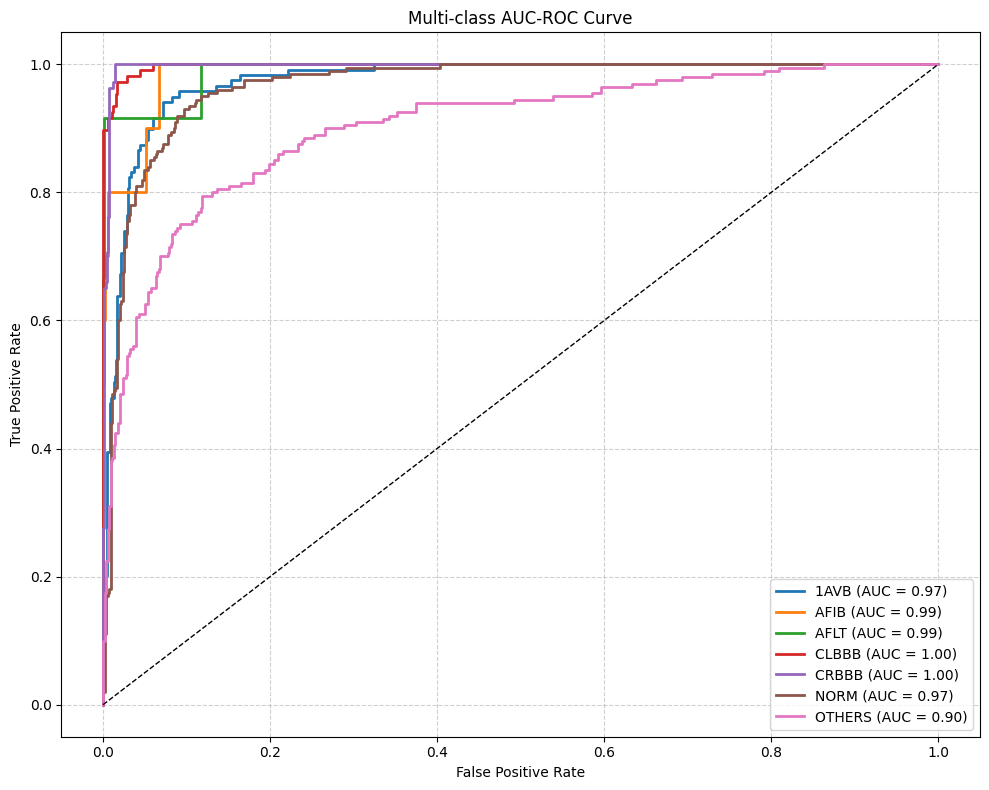

Macro-averaged AUC-ROC: 0.9739


In [59]:
class_names = ['1AVB', 'AFIB', 'AFLT', 'CLBBB', 'CRBBB', 'NORM', 'OTHERS']
plot_auc_roc(model, test_loader, device, class_names)

In [60]:
label_map = {
    0: '1AVB',
    1: 'AFIB',
    2: 'AFLT',
    3: 'CLBBB',
    4: 'CRBBB',
    5: 'NORM',
    6: 'OTHERS'
}

def predict_ecg_npy(npy_path, threshold=0.7):
    data = np.load(npy_path)
    if data.shape == (1000, 12):
        data = data.T
    elif data.shape != (12, 1000):
        raise ValueError(f"Unexpected shape: {data.shape}")

    tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(tensor)
        probs = F.softmax(output, dim=1)
        confidence, pred = torch.max(probs, dim=1)
        pred = pred.item()
        confidence = confidence.item()

    if confidence < threshold:
        return "UNCERTAIN", confidence
    else:
        return label_map[pred], confidence


In [61]:
def test_model_performance(root_dir):
    for folder in sorted(os.listdir(root_dir)):
        npy_path = os.path.join(root_dir, folder, f"{folder}.npy")
        if os.path.isfile(npy_path):
            try:
                pred_label, confidence = predict_ecg_npy(npy_path)
                print(f"{folder}: Predicted Label → {pred_label} (Confidence: {confidence:.4f})")
            except Exception as e:
                print(f"{folder}: Error → {e}")
        else:
            print(f"{folder}: File not found: {npy_path}")

In [62]:
test_model_performance(root_dir)

validation01: Predicted Label → NORM (Confidence: 0.9767)
validation02: Predicted Label → AFLT (Confidence: 0.9963)
validation03: Predicted Label → 1AVB (Confidence: 0.7791)
validation04: Predicted Label → AFIB (Confidence: 0.9808)
validation05: Predicted Label → CRBBB (Confidence: 0.9994)
validation06: Predicted Label → CLBBB (Confidence: 1.0000)


In [63]:
test_model_performance(test_dir)

test01: Predicted Label → 1AVB (Confidence: 0.8615)
test02: Predicted Label → CLBBB (Confidence: 0.9979)
test03: Predicted Label → NORM (Confidence: 0.9940)
test04: Predicted Label → AFLT (Confidence: 0.9271)
test05: Predicted Label → AFIB (Confidence: 0.8588)
test06: Predicted Label → CRBBB (Confidence: 0.9972)
